# Numerical Derivatives and Richardson Extrapolation

Numerical derivatives are used as the basis for many algorithms. Although SciPy does contain a routine for calculating the $n^{\mathrm{th}}$ derivative of a function using center differencing (called `derivative` in `scipy.misc`) we will not be using it.  Center differencing for first order derivatives is simple enough for us to use directly and we will focus on Richardson extrapolation in this example.

## Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

## Richardson Extrapolation

Richards extrapolation is a general approach to improve the accuracy of an algorithm dependent on a step size $\Delta x$.  While we will study it for center differencing below, it can be applied to a wide class of algorithms.  We will see it again in the near future under the name "Romberg integration".

### General Discussion

Suppose we have an algorithm that calculates some quantity as a function of step size, $\Delta x$, to some accuracy $\mathcal{O}(\Delta x^p)$.  We can think of this algorithm as a function of the step size, $F_p(\Delta x)$.  To leading order we can write this function as

$$ F_p(\Delta x) = a_0 + a_p \Delta x^p + \mathcal{O}(\Delta x^r). $$

Here, $a_0$ is the "true value" which we are looking for, and $a_p$ is an error that causes us to deviate from the true value.  The error is $\Delta x^p$, that is, this is the leading order accuracy of our algorithm.  There may also be other errors in our algorithm of order $\Delta x^r$, $r > p$.

Formally, the "true" value of $F_p$ corresponds to the limit where $\Delta x \rightarrow 0$, or $a_0=F_p(0)$ so if we could evaluate $F_p(0)$ we would be done. For Richardson extrapolation, we will instead evalutate $F_p$ for two values of $\Delta x$, and attempt to derive a more accurate expression that eliminates the error $\Delta x^p$.

Notice that if we ignore the terms $\mathcal{O}(\Delta x^r)$ in the expression for $F_p(\Delta x)$ above, then we have a linear equation in two parameters, $a_0$ and $a_p$.  If we can also compute $F_p(\Delta x)$ for some other argument, then we would have two equations for two unknowns which we could solve.  Let $q$ be some number and apply the algorithm for a step size $\Delta x/q$, in addition to the step size $\Delta x$.  With this we then know $F_p(\Delta x)$ and $F_p(\Delta x/q)$, that is, we have the two equations we needed.  Solving these equations we find

$$ a_0 = F_p(\Delta x) - \frac{F_p(\Delta x) - F_p(\Delta x/q)}{1-q^{-p}} + \mathcal{O}(\Delta x^r). $$

This is our estimate for the true value.

Of course this estimate has an error that grows as $\Delta x^r$.  What do we do?  We apply Richardson extrapolation again.  By repeatedly applying this procedure we can remove higher and higher order errors producing a more an more accurate result. (In principle, of course in practice a computer has limited precision so this will eventually fail.)

### Center Differencing

The general discussion is nice, but rather than continue talking in generalities let us look at a specific example to help make sense of the approach.  For center differencing we calculate the derivative of a function, $f(x)$, at the point $x$ using

$$ f'(x) = \frac{f(x+\Delta x)-f(x-\Delta x)}{2\Delta x} + \mathcal{O}(\Delta x^2) + \mathcal{O}(\Delta x^4) + \cdots. $$

In the notation from above this means $p=2$ and $r=4$ and we can write our algorithm as a function of step size $\Delta x$ as

$$ F_2(\Delta x) = \frac{f(x+\Delta x)-f(x-\Delta x)}{2\Delta x}. $$

This estimates the first derivative with an error of $\mathcal{O}(\Delta x^2)$, so it has the form

$$ F_2(\Delta x) = a_0 + a_2 \Delta x^2. $$

Although in principle any $q$ could be chosen, it is convenient to choose $q=2$ so that we evaluate $F_2(\Delta x)$ and $F_2(\Delta x/2)$ using the center differencing equation. This means that

$$ F_2\!\left( \frac{\Delta x}{2} \right) = \frac{f(x+\Delta x/2)-f(x-\Delta x/2)}{\Delta x}. $$

With these values we then get an estimate for the derivative as given in the general discussion,

$$ a_0 = F_2(\Delta x) - \frac{F_2(\Delta x)-F_2(\Delta x/2)}{1- 1/4} \equiv F_4(\Delta x). $$

As noted, we call this estimate $F_4(\Delta x)$ and we can improve it by again applying Richardson extrapolation.  For center differencing we saw that our first estimate will have a residual error $\mathcal{O}(\Delta x^4)$.  Thus we can write it as

$$ F_4(h) = F_2(\Delta x) + a_4 \Delta x^4. $$

An estimate for $a_4$ is then given by

$$ a_4 = F_4(\Delta x) - \frac{F_4(\Delta x)-F_4(\Delta x/2)}{1-1/16} \equiv F_6(\Delta x). $$

We can then repeat the procedure on $F_6(\Delta x)$, *etc*.  Notice that to calculate $F_6(\Delta x)$ we need $F_4(\Delta x/2)$, how do we calculate this?  This is just another case of the general result we have been using,

$$ F_4(\Delta x/2) = F_2(\Delta x/2) - \frac{F_2(\Delta x/2)-F_2(\Delta x/4)}{1-1/4}. $$

Thus, even if we have a complicated algorithm (unlike center differencing which is very simple and quick to calculate), we can easily improve the accuracy of an estimate.

## Implementation

Here is an implementation of Richardson extrapolation for center differencing.  It sacrifices a little in efficiency for readability.

In [2]:
def richardson_center (f, z, h, nsteps, args=()) :
    """Evaluate the first derivative of a function at z, that is f'(z),
    using Richardson extrapolation and center differencing.

    Returned is the full table of approximations, Fij for j <= i. The
    values of Fij for j > i are set to zero.  The final value F[-1,-1]
    should be the most accurate estimate.

    Parameters
    ----------
    f : function
        Vectorized Python function.
        This is the function for which we are estimating the derivative.
    z : number
        Value at which to evaluate the derivative.
    h : number
        Initial stepsize.
    nsteps : integer
        Number of steps to perform.
    args : tuple, optional
        extra arguments to pass to the function, f.
    """
    # Extra check to allow for args=(1) to be handled properly.  This is a
    # technical detail that you do not need to worry about.
    if not isinstance(args, (tuple, list, np.ndarray)) :
        args = (args,)
    # Create a zero filled table for our estimates
    F = np.zeros((nsteps,nsteps))
    # First column of F is the center differencing estimate.  We can fill this
    # without a loop!
    harr = h / 2.**np.arange(nsteps)
    F[:,0] = (f(z+harr,*args) - f(z-harr,*args)) / (2.*harr)
    # Now iterate, unfortunately we do need one loop.  We could
    # get rid of the inner loop but the algorithm is a little easier to
    # understand if we do not.
    for i in range(1,nsteps) :
        fact = 0.25
        for j in range(1,i+1) :
            F[i,j] = F[i-1,j-1] - (F[i-1,j-1] - F[i,j-1])/ (1-fact)
            fact *= 0.25
    return F

## Example 1

As a test case consider the function
$$ f(x) = \mathrm{e}^{-x} \sin x$$
which has the derivative
$$ f'(x) = -f(x) + \mathrm{e}^{-x} \cos x.$$
We will calculate the derivative at $x=1$ using a step $\Delta x=0.9$.

In [12]:
# Define the function and its derivative
def f(x) :
    return np.exp(-x)*np.sin(x)

def fderiv(x) :
    return -f(x) + np.exp(-x)*np.cos(x)

In [4]:
# Set up conditions and use Richardson extrapolation.
z = 1.0
# As always we calculate the stepsize as a number that can be
# "exactly" represented numerically.
h10 = 0.9
h = h10 + z
h -= z
N = 6
F = richardson_center(f, z, h, N)
F

array([[ 0.02844655,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.07633703, -0.11126489,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.1022064 , -0.11082953, -0.11080051,  0.        ,  0.        ,
         0.        ],
       [-0.10864868, -0.1107961 , -0.11079387, -0.11079376,  0.        ,
         0.        ],
       [-0.1102576 , -0.11079391, -0.11079377, -0.11079377, -0.11079377,
         0.        ],
       [-0.11065973, -0.11079377, -0.11079377, -0.11079377, -0.11079377,
        -0.11079377]])

Notice that the result comes back in a two dimensional array.  The first column constains the estimates from center differencing with step sizes halved in each row ("step"), and the diagonal the improved estimates from Richardson extrapolation at each step.  We can easily access these elements of the array using array slicing and the `diag` function.

To more simply see the results we make a plot.  Notice that Richardson extrapolation happened to get very close to the true value on the second step, which corresponds to $F_4(\Delta x)$.

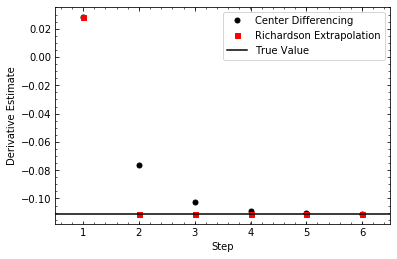

In [5]:
nstep = np.arange(N)+1
plt.plot(nstep, F[:,0], 'ko', ms=5, label='Center Differencing')
plt.plot(nstep, np.diag(F), 'rs', ms=5, label='Richardson Extrapolation')
plt.axhline(fderiv(z), color='k', label='True Value')
plt.xlim(0.5, nstep[-1]+0.5)
plt.legend(loc='best')
plt.xlabel('Step')
plt.ylabel('Derivative Estimate');

### Fractional Errors

From the above plot it is hard to gauge the improvements that Richardson extrapolation provide.  Below we plot the fractional errors in the estimates.

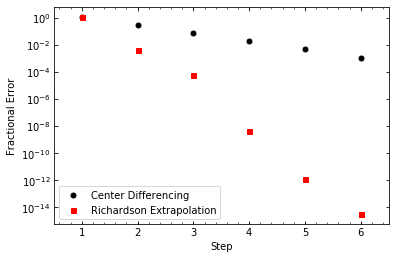

In [6]:
cd_err = np.abs(1-F[:,0]/fderiv(z))
re_err = np.abs(1-np.diag(F)/fderiv(z))
plt.semilogy(nstep, cd_err, 'ko', ms=5, label='Center Differencing')
plt.semilogy(nstep, re_err, 'rs', ms=5, label='Richardson Extrapolation')
plt.xlim(0.5, nstep[-1]+0.5)
plt.legend()
plt.xlabel('Step')
plt.ylabel('Fractional Error');

In general we see that Richardson extrapolation offers significant improvements! This is not always the case, but it is so simple to calculate that if we have gone through the trouble of calculating $F_1$ for various step sizes it would be silly to not combine them using Richardson extrapolation.